In [1]:
# The instrument response and source injector

In out energy range trad detector

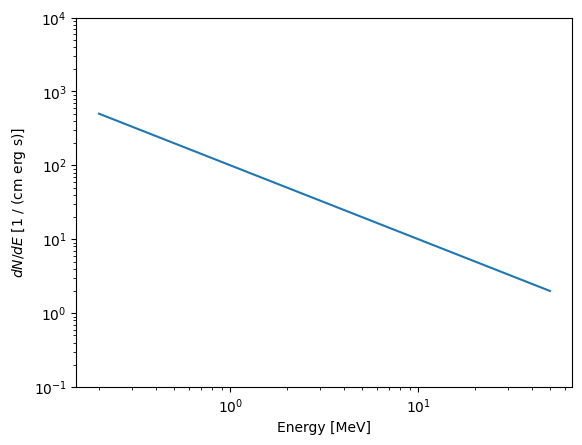

In [13]:
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = -1, 
                                                min_energy = 200*u.keV,
                                                max_energy = 50*u.MeV),
                     flux_pivot = 1e2/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

source.plot_spectrum();

In [2]:
np.array(5*u.cm)

array(5.)

Same flux per decade. Equivalent to nufnu (ref)

About a min

In [14]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum
import matplotlib.pyplot as plt

# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)
# Getting Em and the CDS
reco = SimpleTraditionalReconstructor()

# Sims
sims = Simulator(detector = det, 
                 sources = source, 
                 reconstructor = reco)

# Let's change the binning default since we're looking
# at a "continuum" source --i.e. with no narrow energy lines
# Em slightly larger to capture errors
sims.photon_energy_axis = np.geomspace(200*u.keV, 50*u.MeV, 31)
sims.measured_energy_axis = np.geomspace(100*u.keV, 60*u.MeV, 11)

In [15]:
duration = 1*u.hour
h_data, h_sim = sims.run_binned(duration = duration, axes = 'Em', photon_axes = 'Ei')

We simulated 3.6e+03 s (3325) and detected 1083


Text(0, 0.5, 'Counts')

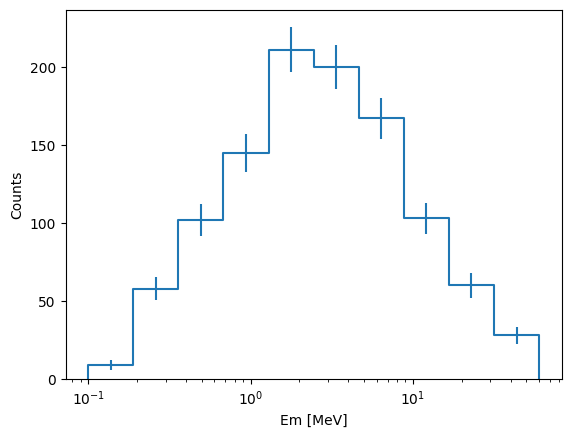

In [17]:
# Summary and plot
print(f"We simulated {sims.duration:.2} ({sims.nsim}) and detected {sims.ntrig}")

h_Em = h_data.project('Em')

ax,_ = h_Em.plot(errorbars = True)
ax.set_ylim(0,None)
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

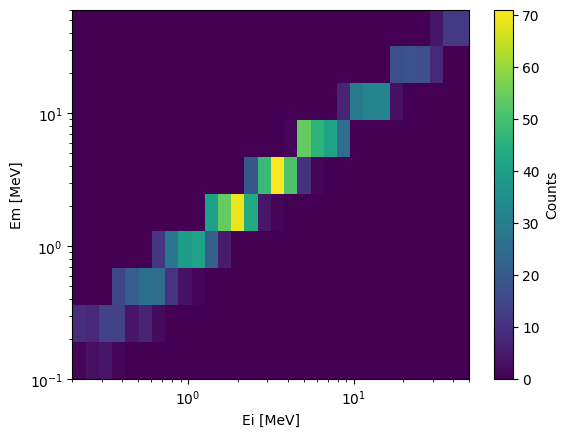

In [18]:
ax,_ = h_data.plot()
colorbar = ax.get_figure().axes[-1]
colorbar.set_ylabel("Counts")

(0.0, 139.65)

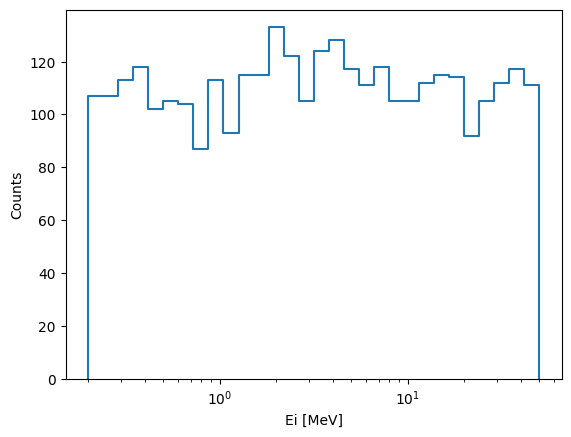

In [19]:
ax,_ = h_sim.plot()
ax.set_ylabel('Counts')
ax.set_ylim(0,None)

In [22]:
%%time

create_my_own = False

if create_my_own:
    
    h_data, h_sim = sims.run_binned(ntrig = 10000, axes = 'Em', photon_axes = 'Ei')
    
    response = h_data * (det.throwing_plane_size / h_sim.contents)[:,None] 
    
    response.write("spectral_response_onaxis_traddet.h5", overwrite = True)
    
else:

    from histpy import Histogram
    response = Histogram.open("spectral_response_onaxis_traddet.h5")

CPU times: user 4.67 ms, sys: 2.74 ms, total: 7.42 ms
Wall time: 5.38 ms


Text(0, 0.5, 'Area [m]')

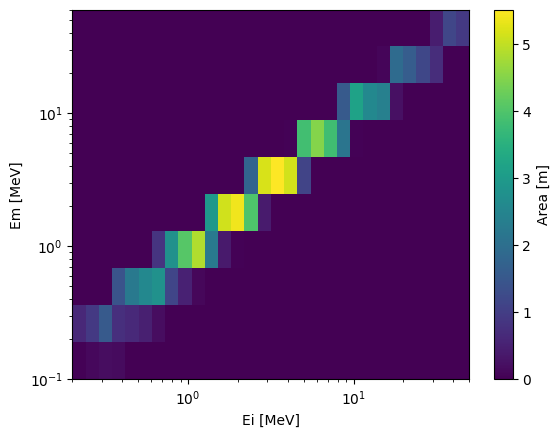

In [23]:
ax,_ = response.plot()

colorbar = ax.get_figure().axes[-1]
colorbar.set_ylabel(f"Area [{response.unit}]")

Only integrated withing min/max Em

Text(0, 0.5, 'Area [m]')

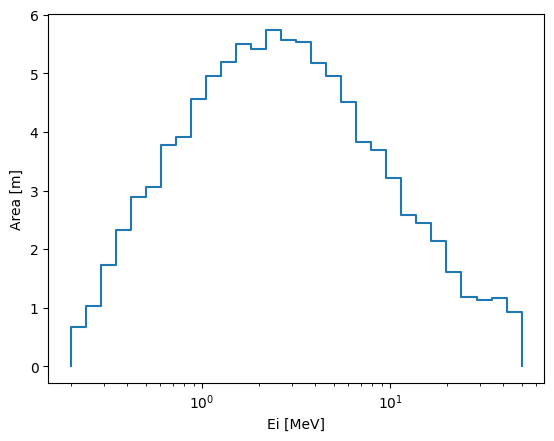

In [24]:
Aeff = response.project('Ei')
ax,_ = Aeff.plot()
ax.set_ylabel(f"Area [{response.unit}]")

(<Axes: xlabel='Ei [MeV]', ylabel='Em [MeV]'>,
 <matplotlib.collections.QuadMesh at 0x12ade72d0>)

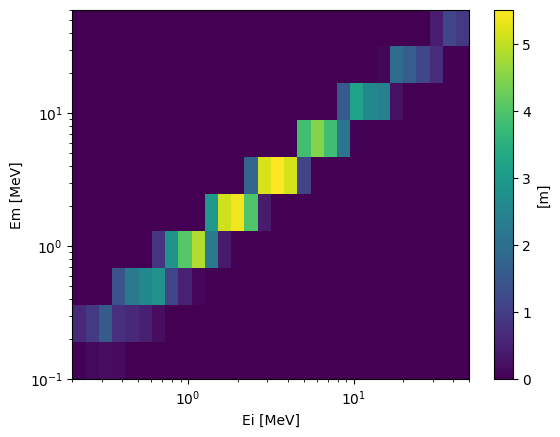

In [25]:
response.plot()

/Users/imartin5/burstcube/software/histpy/histpy/histogram.py:1481: RuntimeWarning: invalid value encountered in divide
  self._contents = operation(self.full_contents, other)


(<Axes: xlabel='Ei [MeV]', ylabel='Em [MeV]'>,
 <matplotlib.collections.QuadMesh at 0x12aff8cd0>)

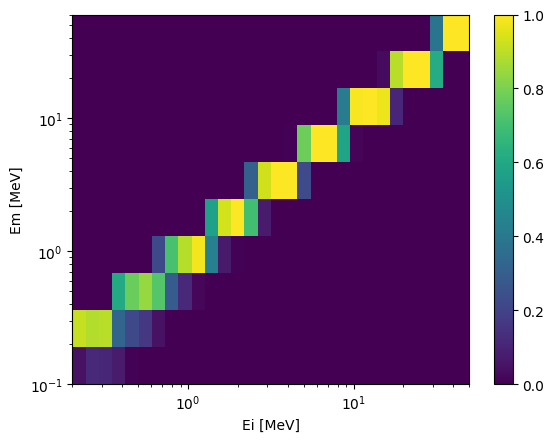

In [26]:
energy_dispersion = response/response.project('Ei').contents[:,None]

energy_dispersion.plot()

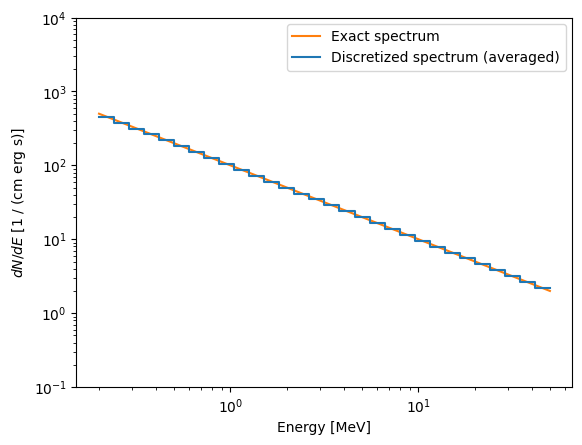

In [28]:
from histpy import Histogram

y_units = 1/u.erg/u.cm/u.s

binned_spec = source.discretize_spectrum(response.axes['Ei'])

ax,_ = (binned_spec / binned_spec.axis.widths).to(y_units).plot(label = 'Discretized spectrum (averaged)')

source.plot_spectrum(ax, label = 'Exact spectrum', y_units = y_units);

ax.legend()

Fast, mean!

Text(0, 0.5, 'Counts')

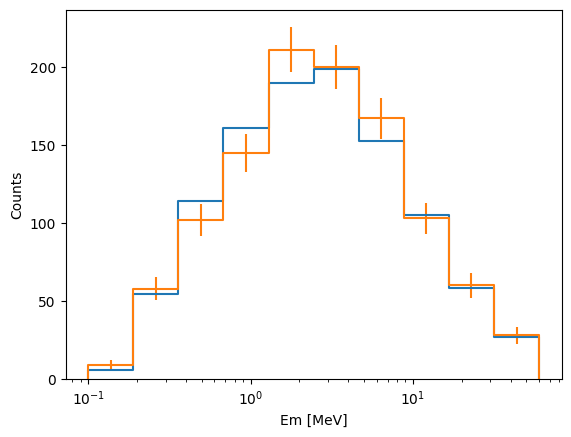

In [31]:
# Fast
binned_spec = Histogram(response.axes['Ei'],
                        unit = 1/u.cm/u.s,
                        contents = source.integrate_flux(response.axes['Ei'].lower_bounds, 
                        response.axes['Ei'].upper_bounds))

expected_counts = np.dot(response.contents.transpose(), duration*binned_spec.contents).to_value('')
h_Em_from_response = Histogram(response.axes['Em'],
                               contents = expected_counts)

ax,_ = h_Em_from_response.plot()

h_Em.plot(ax, errorbars = True)

ax.set_ylim(0,None)
ax.set_ylabel('Counts')

Poisson fluctuate

## Wraping things up

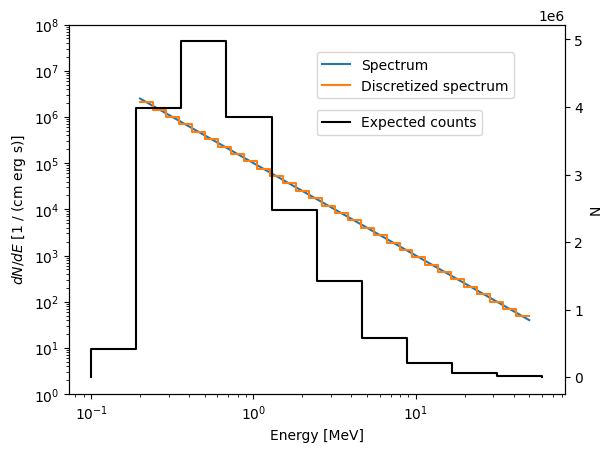

In [33]:
from gammaraytoys.detectors import PowerLawSpectrum, PointSource
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = PowerLawSpectrum(index = -2, 
                                                min_energy = 200*u.keV,
                                                max_energy = 50*u.MeV),
                     flux_pivot = 1e5/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

response = SpectralResponse.open("spectral_response_onaxis_traddet.h5")

expected_counts = response.expected_counts(source, 1*u.day)

fig,axl = plt.subplots()

source.plot_spectrum(axl, label = 'Spectrum');
source.plot_spectrum(axl, discretize_axis = response.photon_energy_axis, label = 'Discretized spectrum');
axl.legend(loc = (.5,.8))

axr = axl.twinx()
expected_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.5,.7))